In [1]:
from odps import ODPS
from odps import options
from odps.df import DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# connect信息
from ACCESS import ACCESS_ID
from ACCESS import SECRET_ACCESS_KEY
from ACCESS import ODPS_PROJECT
from ACCESS import ODPS_ENDPOINT

# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY,
         project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000
print("数据库连接成功！")

# ods_github_log = DataFrame(o.get_table('ods_github_log'))
# ods_github_users = DataFrame(o.get_table('ods_github_users'))
# dim_github_actor = DataFrame(o.get_table('dim_github_actor'))
# dim_github_pr = DataFrame(o.get_table('dim_github_pr'))
dim_github_repo = DataFrame(o.get_table('dim_github_repo'))
print("获取表成功！")

数据库连接成功！
获取表成功！


In [2]:
select_sql ='''
SELECT MAX(repo_stargazers_count) AS "max_star", MAX(repo_forks_count) AS "max_fork"
FROM dim_github_repo
WHERE repo_has_pr = 0
'''
table = o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        print(record)

odps.Record {
  max_star        0
  max_fork        0
}


In [3]:
df = pd.DataFrame(columns=['feature', 'boolean', 'avg_star', 'avg_fork', "num_star", "num_fork"])

features = ['issues', 'projects', 'downloads', 'wiki', 'pages']
for feature in features:

    select_sql =f'''
    SELECT
        repo_has_{feature} AS "boolean", 
        AVG(repo_stargazers_count) AS "avg_star", AVG(repo_forks_count) AS "avg_fork", 
        COUNT(repo_stargazers_count) AS "num_star", COUNT(repo_forks_count) AS "num_fork"
    FROM dim_github_repo
    WHERE repo_has_pr = 1
    GROUP BY repo_has_{feature}
    '''
    
    table = o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})
    with table.open_reader(tunnel=True) as reader:
        for record in reader:
            df = df.append({
                'feature':feature, 'boolean':record.boolean, 
                'avg_star':record.avg_star, 'avg_fork':record.avg_fork, 
                'num_star':record.num_star, "num_fork":record.num_fork}, ignore_index=True)

In [4]:
df

,feature,boolean,avg_star,avg_fork,num_star,num_fork
0,issues,0,1.354263,0.929228,3122676,3122676
1,issues,1,10.208270,3.056940,18236837,18236837
2,projects,0,5.480377,1.770945,2535052,2535052
3,projects,1,9.376228,2.877169,18824461,18824461
4,downloads,0,26.746578,7.628615,112662,112662
5,downloads,1,8.819291,2.719986,21246851,21246851
6,wiki,0,21.916285,7.588058,1070937,1070937
7,wiki,1,8.227513,2.490281,20288576,20288576
8,pages,0,6.886797,2.341369,19604986,19604986
9,pages,1,31.564014,7.265831,1754527,1754527


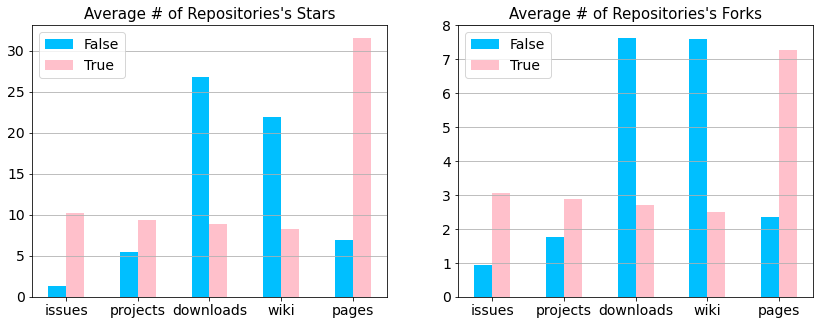

In [6]:
plt.figure(figsize=(14, 5))
x = np.arange(len(features))  # x轴刻度标签位置
width = 0.25  # 柱子的宽度
metrics = ['star', 'fork'] # 衡量指标

for idx, metric in enumerate(metrics):

    plt.subplot(1,2,idx+1)

    col_name = f'avg_{metric}'
    plt.bar(x - width/2, df.loc[df['boolean']==0, :][col_name], width=width, label='False', fc='deepskyblue')
    plt.bar(x + width/2, df.loc[df['boolean']==1, :][col_name], width=width, label='True', fc='pink')
    plt.title(f'Average # of Repositories\'s {metric.capitalize()}s', size=15)
    plt.xticks(ticks=x, labels=features, size=14)
    plt.yticks(size=14)
    plt.grid(axis="y")
    plt.legend(fontsize=14)
plt.show()

In [8]:
select_sql ='''
SELECT repo_has_pages, repo_has_wiki, AVG(repo_stargazers_count) AS "avg_star", AVG(repo_forks_count) AS "avg_fork"
FROM dim_github_repo
WHERE repo_has_pr = 1
GROUP BY repo_has_pages, repo_has_wiki
'''
table = o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        print(record)

odps.Record {
  repo_has_pages              0
  repo_has_wiki               0
  avg_star                    17.77989352177461
  avg_fork                    6.970622486481523
}
odps.Record {
  repo_has_pages              0
  repo_has_wiki               1
  avg_star                    6.326962811801015
  avg_fork                    2.1034549979653203
}
odps.Record {
  repo_has_pages              1
  repo_has_wiki               0
  avg_star                    57.1144211900301
  avg_fork                    12.842051518837852
}
odps.Record {
  repo_has_pages              1
  repo_has_wiki               1
  avg_star                    29.811503445990883
  avg_fork                    6.883355827488507
}
